# EDA (Exploratory Data Analysis)

This notebook is used to perform data exploration before starting any machine learning model. It is important to correctly analyze the source data, the data type and the characteristics of all columns.

#### How to install libraries?

In [2]:
!pip install boto3==1.19.12
!pip install s3fs

  Using cached boto3-1.19.12-py3-none-any.whl (131 kB)
  Using cached botocore-1.22.12-py3-none-any.whl (8.1 MB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
  Using cached s3transfer-0.5.2-py3-none-any.whl (79 kB)
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmespath-1.0.1:
      Successfully uninstalled jmespath-1.0.1
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.69
    Uninstalling botocore-1.29.69:
      Successfully uninstalled botocore-1.29.69
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.6.0
    Uninstalling s3transfer-0.6.0:
      Successfully uninstalled s3transfer-0.6.0
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.69
    Uninstalling boto3-1.26.69:
      Successfully uninstalled boto3-1.26.69
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

#### Imports

In [3]:
import pandas as pd
# To display all columns
pd.set_option('display.max_columns', None)
# To display float format with 3 digits
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
import numpy as np
import datetime
import boto3
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Paths

In [4]:
dir_data = 's3://iberia-data-lake/sagemaker/sagemaker-template/titanic_database'

#### Read data

In [5]:
df_train = pd.read_csv(f"{dir_data}/train.csv")
df_test = pd.read_csv(f"{dir_data}/test.csv")

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [8]:
df_train.shape

(891, 12)

In [9]:
df_test.shape

(418, 11)

There are 891 for training with 12 columns (including the model label) and 418 for testing the model.

#### Data type

In [10]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

- The PK is PassengerID and is an integer. 

- The model label is in integer format and is Survived.

- We have three other columns in integer format (Pclass, SibSp, Parch).

- As float we have Age and Fare.

- Finally, the columns Name, Sex, Ticket, Cabin and Embarked are treated as objects.

#### Data describe

In [11]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The first thing to note is that all columns are reported except Age and Cabin, so we will have to treat them. The PassengerId is increasing and goes from 1 to 891. On the other hand, it is observed that in training only 38.4% survived. The other variables come well reported and will have to be examined well to understand their values.

#### Variables correlation

Correlation matrix

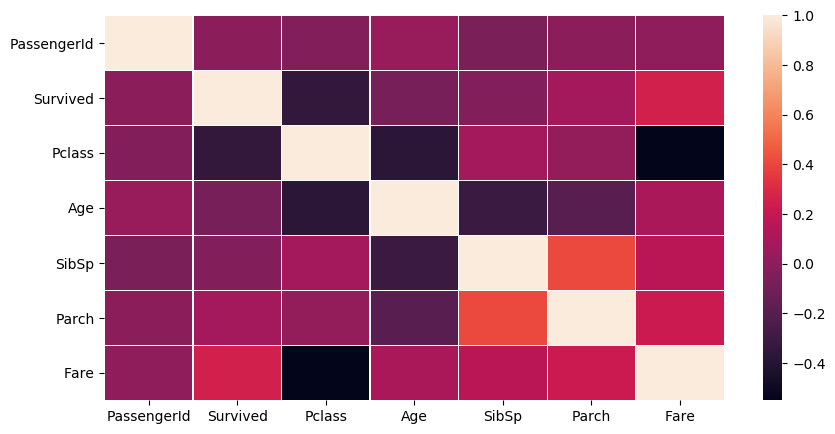

In [17]:
matrix = df_train.corr().round(2)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(matrix, linewidths=.2, ax=ax)
plt.show()

Top 5 correlations

In [19]:
df_corr = matrix.stack().reset_index()
df_corr = df_corr[df_corr['level_0'] != df_corr['level_1']]
df_corr['absolute_corr'] = abs(df_corr[0])
df_corr.sort_values(by='absolute_corr', ascending=False)[0:5]

,level_0,level_1,0,absolute_corr
44,Fare,Pclass,-0.550,0.550
20,Pclass,Fare,-0.550,0.550
39,Parch,SibSp,0.410,0.410
33,SibSp,Parch,0.410,0.410
23,Age,Pclass,-0.370,0.370


The variables that correlate most with each other are Fare and Pclass, which is related to the fare and the class in which passengers traveled (with negative correlation). The same occurs with SibSp but with positive correlation. It may be interesting to treat these variables differently in order to eliminate the correlation and provide different information to the model.

On the other hand, it is observed that the variable that correlates most with output is Pclass.

#### Plot samples

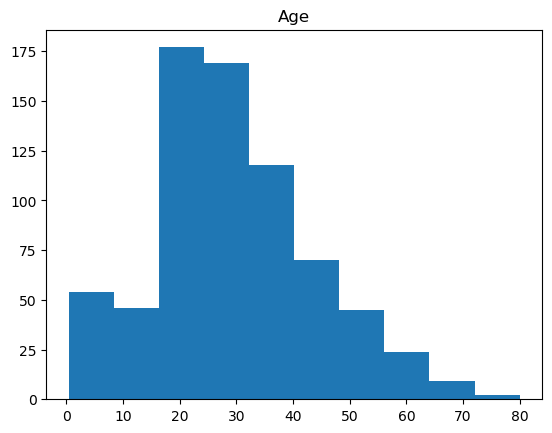

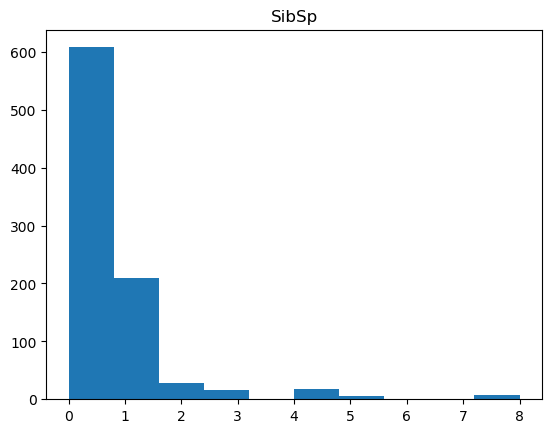

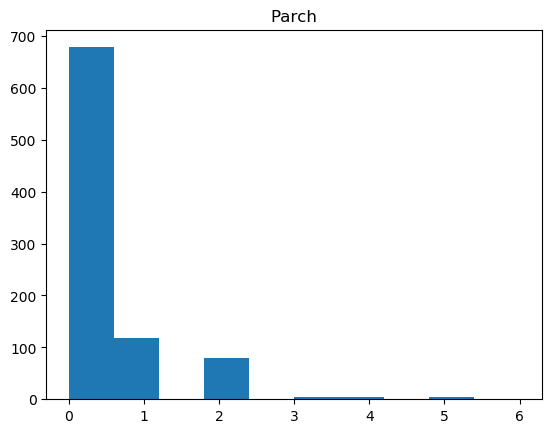

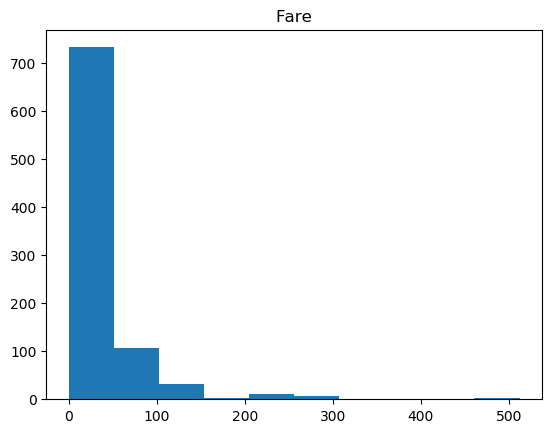

In [15]:
num = ['Age','SibSp','Parch','Fare']
for i in num:
    plt.hist(df_train[i])
    plt.title(i)
    plt.show()

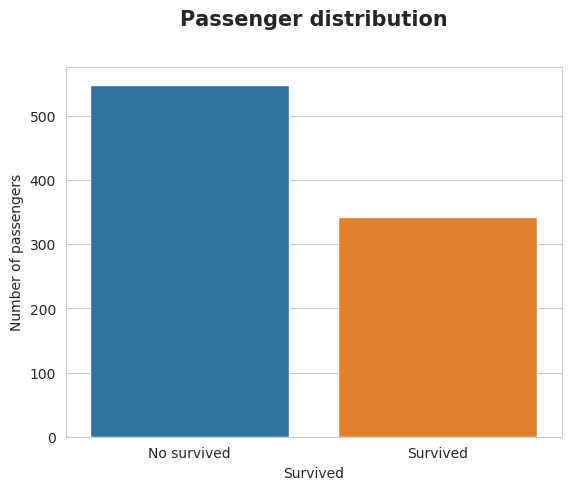

In [26]:
df_train_gpby = df_train.groupby('Survived')['PassengerId'].count().reset_index().replace({0: 'No survived', 1: 'Survived'})
sns.set_style('whitegrid')
ax = sns.barplot(x=df_train_gpby['Survived'], y=df_train_gpby['PassengerId'])
plt.title('Passenger distribution', pad=30, fontsize=15, fontweight='bold')
plt.ylabel('Number of passengers')
plt.show()
fig = ax.get_figure()
# To save figure
# fig.savefig('../plots/survived_vs_no_survived.png')

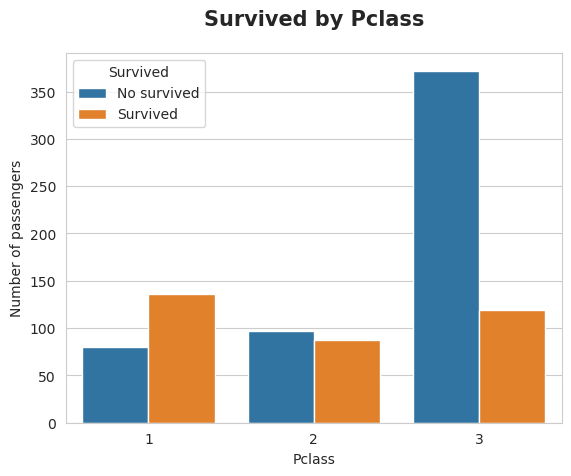

In [35]:
df_train_gpby = df_train.groupby(['Survived', 'Pclass'])['PassengerId'].count().reset_index()
df_train_gpby['Survived'] = df_train_gpby['Survived'].replace({0: 'No survived', 1: 'Survived'})
sns.set_style('whitegrid')
sns.barplot(x=df_train_gpby['Pclass'], y=df_train_gpby['PassengerId'], hue=df_train_gpby['Survived'])
plt.title('Survived by Pclass', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of passengers')
plt.show()

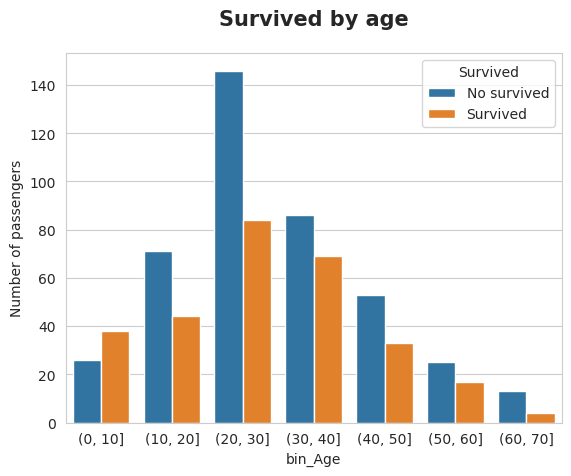

In [38]:
bins = [0,10,20,30,40,50,60,70]
field = 'Age'
bin_field = 'bin_' + field
df_train[bin_field] = pd.cut(df_train[field], bins=bins)
df_train_gpby = df_train.groupby(['Survived', bin_field])['PassengerId'].count().reset_index()
df_train_gpby['Survived'] = df_train_gpby['Survived'].replace({0: 'No survived', 1: 'Survived'})
sns.set_style('whitegrid')
sns.barplot(x=df_train_gpby[bin_field], y=df_train_gpby['PassengerId'], hue=df_train_gpby['Survived'])
plt.title('Survived by age', pad=20, fontsize=15, fontweight='bold')
plt.ylabel('Number of passengers')
plt.show()